 # Tutorial for Gromov-Wassserstein unsupervised alignment 

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../'))

import numpy as np
import pandas as pd
import pickle as pkl

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

# Step1: Prepare dis-similarity matrices
First, you need to prepare dis-similarity (distance) matrices from your data.  
Then, you need to input the similarity matrices into the list "representations" as follows.  
This list constains instances "Representation" where "name" means the names of similarity matrices, which are used for the filename.

## Load data
you can choose the following data
1. 'color': human similarity judgements of 93 colors for 5 paricipants groups
1. 'THINGS' : human similarity judgements of 1854 objects for 4 paricipants groups

"data_select" in next code block can define which dataset are going to be used.

In [2]:
# list of representations where similarity matrices are included
representations = list()

# select data
data_select = "THINGS"

### Dataset No1. `color`
For this data, we directly input similarity matrices of 93 colors into "representations".

In [3]:
# Load data and create "Representation" instance
if data_select == 'color':
    n_representations = 5 # Set the number of representations. This number must be equal to or less than the number of groups.
    metric = "euclidean" # Please set metric that can be used in "scipy.distance.cdist()"
    
    data_path = '../data/num_groups_5_seed_0_fill_val_3.5.pickle'
    with open(data_path, "rb") as f:
        data = pkl.load(f)
    sim_mat_list = data["group_ave_mat"]
    for i in range(n_representations):
        name = f"Group{i+1}" # "name" will be used as a filename for saving the results
        sim_mat = sim_mat_list[i] # similarity matrix of group i
        # make an instance "Representation" with settings 
        representation = Representation(
            name = name, 
            metric = metric,
            sim_mat = sim_mat,  #: np.ndarray
            embedding = None,   #: np.ndarray 
            get_embedding = False, # Default is False.
            MDS_dim = 3, # used for visualization
            object_labels = None,
            category_name_list = None,
            num_category_list = None,
            category_idx_list = None,
            func_for_sort_sim_mat = None,
       ) 
        representations.append(representation)

### Dataset No.2 `THINGS`
For this data, we input embeddings of each object into representations and then, compute similarity matrices from the embeddings.  
This dataset has information of category labels. We demonstrate how to define it below.

In [4]:
if data_select == "THINGS":
    # define the label information of the dataset
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)
    
    # define the parameters for category (or label) info. 
    # Users can define these by themselves if they use a different dataset and the format of parameters are the same.
    # get_category_data and sort_matrix_with_categories are functions specialied for this dataset
    from src.utils.utils_functions import get_category_data, sort_matrix_with_categories
    object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat)
    
    n_representations = 4 # Set the number of representations. This number must be equal to or less than the number of groups.
    metric = "euclidean" # Please set metric that can be used in "scipy.distance.cdist()"
    
    for i in range(n_representations):
        name = f"Group{i+1}"
        embedding = np.load(f"../data/THINGS_embedding_Group{i+1}.npy")[0]
        
        representation = Representation(
            name = name, 
            embedding = embedding, # the similarity matrix will be calculated by this embedding.
            metric = metric,
            get_embedding = True, # Default is False. If True, the similarity matrix will be calculated by the embedding.
            object_labels = object_labels,
            category_name_list = category_name_list,
            category_idx_list = category_idx_list,
            num_category_list = num_category_list,
            func_for_sort_sim_mat = sort_matrix_with_categories
        )
        
        representations.append(representation)

# Step 2: Set the parameters for the optimazation of GWOT

## Optimization Config  

#### Most important options to check for your application:
`eps_list, num_trial` are essential for computing the GW alignment.  
You can first use default values for the other options.  

You need to choose appropriate ranges of epsilon, "eps_list".  
If epsilon is not in appropriate ranges, the optimization may not work properly.  
Also, epsilon range is critical for finding good local optimum.  

In [5]:
config = OptimizationConfig(
    ### Set the range of epsilon
    # set only the minimum value and maximum value for 'tpe' sampler
    # for 'grid' or 'random' sampler, you can also set the step size
    eps_list = [1, 10], # [1, 10] for THINGS data, [0.02, 0.2] for colors data
    eps_log = True, # whether epsilon is sampled at log scale or not
    num_trial = 4, # set the number of trials, i.e., the number of epsilon values evaluated in optimization. default : 20
    sinkhorn_method='sinkhorn_log', # please choose the method of sinkhorn implemented by POT (URL : https://pythonot.github.io/gen_modules/ot.bregman.html#id87). For using GPU, "sinkhorn_log" is recommended.
    
    ### Set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
    to_types = 'torch', # user can choose "numpy" or "torch". please set "torch" if one wants to use GPU.
    device = 'cuda', # "cuda" or "cpu"; for numpy, only "cpu" can be used. 
    
    ### Parallel Computation (requires n_jobs > 1, available both for numpy and torch)
    n_jobs = 4, # n_jobs : the number of worker to compute. if n_jobs = 1, normal computation will start. 
    parallel_method = "multithread", # "multiprocess" or "multithread". Default is "multithread".
    multi_gpu = [1,2], # This parameter is only for "torch". # "True" : all the GPU installed in your environment, "list (e.g.[0,2,3])"" : cuda:0,2,3, and "False" : single gpu (or cpu for numpy) will use.
    
    ### Set the database URL to store the optimization results (either PyMySQL or SQLite. For using PyMySQL, some additional setting beforehand will be needed).  
    # To use remote databases, you need to start the database server beforehand. For detailed instruction, please refer to the Optuna official tutorial:  
    # https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html  
    
    storage = None, # When using SQLite, the database file is automatically created, so you only need to set None.
    # storage = 'mysql+pymysql://root@localhost/oizumi',
    
    ### Set the parameters for optimization
    # 1. initialization of transportation plan
    # 2. 'uniform': uniform matrix, 'diag': diagonal matrix
    # 3. 'random': random matrix, 'permutation': permutation matrix
    # you can select multiple options (e.g. init_plans_list = ['uniform', 'random'])
    init_plans_list = ['random'],
    
    ### Set the parameters for optimization
    # n_iter : the number of random initial matrices for 'random' or 'permutation' options：default: 100
    # max_iter : the maximum number of iteration for GW optimization: default: 1000
    n_iter = 1,
    max_iter = 200,
    
    ### folder or file name when saving the result
    # Optimization results are saved in the folder by "config.data_name" + "representations.name" vs "representation.name".
    # If you want to change the name of the saved folder, please change "config.data_name" and "representations.name".
    data_name = data_select, # Please rewrite this name if users want to use their own data.
    
    ### user can delete the result data if existed and they want.  
    # Delete previous optimization results or not  
    # If the same filename has different search space, optuna may not work well.
    delete_study = False, 
    
    ### choose sampler implemented by Optuna
    # 1. 'random': randomly select epsilon between the range of epsilon
    # 2. 'grid': grid search between the range of epsilon
    # 3. 'tpe': Bayesian sampling
    sampler_name = 'tpe',
    
    ### choose pruner
    # 1. 'median': Pruning if the score is below the past median at a certain point in time  
    #     n_startup_trials: Do not activate the pruner until this number of trials has finished  
    #     n_warmup_steps: Do not activate the pruner for each trial below this step  
        
    # 2. 'hyperband': Use multiple SuccessiveHalvingPrunerd that gradually longer pruning decision periods and that gradually stricter criteria  
    #     min_resource: Do not activate the pruner for each trial below this step  
    #     reduction_factor: How often to check for pruning. Smaller values result in more frequent pruning checks. Between 2 to 6.  
        
    # 3. 'nop': no pruning
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    },
)

## VisualizationConfig
VisualizationConfig will help user to make the figure to visualize the results of GW alignment. 

For here, we just want to introduce all the parameters will be used for this instance, and we will change some of them later for each dataset.

Please keep in mind that user can get the raw results data if they want to make the figures by themselves.  

In [6]:
visualize_matrix = VisualizationConfig(
    ### Please set the parameters below that can be used in "mttplotlib.pyplot"
    figsize=(8, 6), 
    title_size = 15, 
    cmap = 'cividis',
    cbar_ticks_size=20,
    ticks_size=5,
    xticks_rotation=90,
    yticks_rotation=0,
    legend_size=5,
    xlabel=None,
    xlabel_size=15,
    ylabel=None,
    ylabel_size=15,
    zlabel=None,
    zlabel_size=15,
    color_labels=None,
    color_hue=None,
    markers_list=None,
    marker_size=30,
    
    ### Set the parameters for showing the boundary of category or label info if the dataset have. If not, please draw_category_line = False.
    draw_category_line=True,
    category_line_color='C2',
    category_line_alpha=0.2,
    category_line_style='dashed',
)

## Step 3 : Unsupervised alignment between Representations
For GW aligment, we create an instance "AlignRepresentations" where we put the list of instance "representations".  
The instance "AlignRepresentations" has methods for Representation Similarity Analysis (RSA), Gromov-Wasserstein (GW) alignment, the evaluation of the GW alignment.  

This instance will compute all the pairs based on `representations_list` we defined at the beggining of this notebook.   
If you want to limit the pairs that are applied GW alignment, please set “AlignRepresentations.pair_number_list”. (e.g. pair_number_list = [[0, 1], [0, 2]])

In [7]:
# Create an "AlignRepresentations" instance
align_representation = AlignRepresentations(
    representations_list=representations,
    pair_number_list='all', #If you want to limit the pairs that are applied GW alignment, please set “AlignRepresentations.pair_number_list”. (e.g. pair_number_list = [[0, 1], [0, 2]])
    histogram_matching=False,
    config=config,
    metric="cosine", # 武田さんにコメントを書いてもらう。
)

Pair number 0 : Group1 vs Group2
Pair number 1 : Group1 vs Group3
Pair number 2 : Group1 vs Group4
Pair number 3 : Group2 vs Group3
Pair number 4 : Group2 vs Group4
Pair number 5 : Group3 vs Group4


## Show similarity matrices

In [8]:
## Dataset No.1 : color 
if data_select == "color":
    sim_mat_format = "default"
    visualize_matrix = VisualizationConfig(figsize=(8, 6), title_size = 15)
    sim_mat = align_representation.show_sim_mat(
        sim_mat_format = sim_mat_format, 
        visualization_config = visualize_matrix,
    )

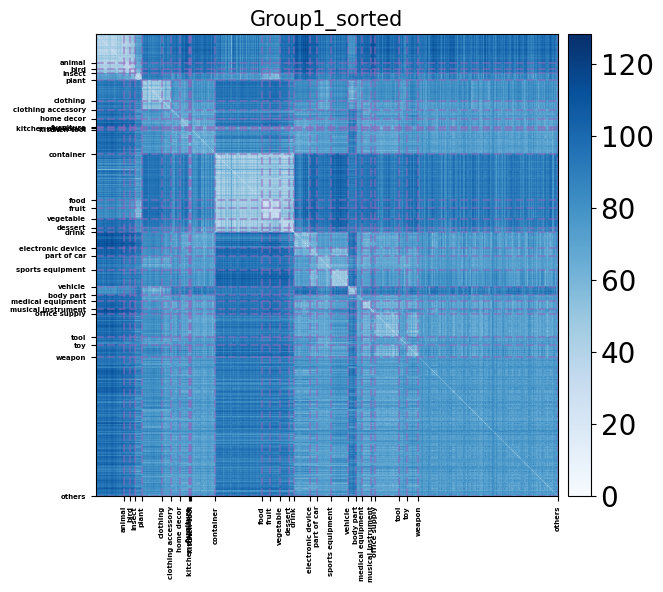

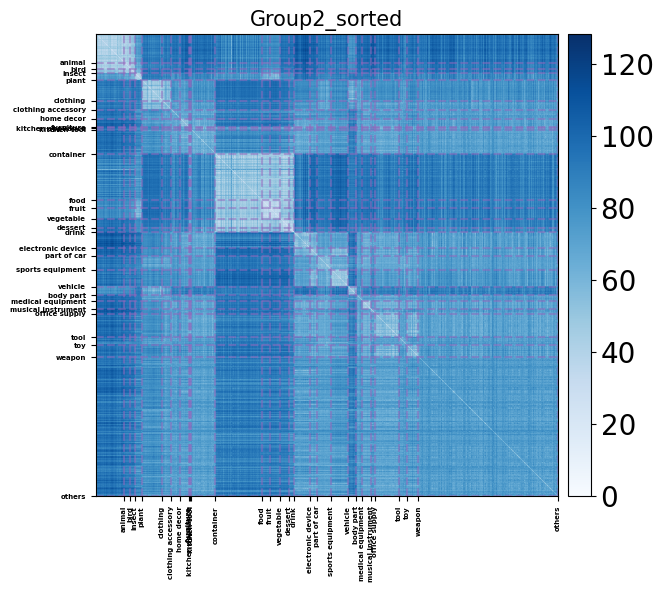

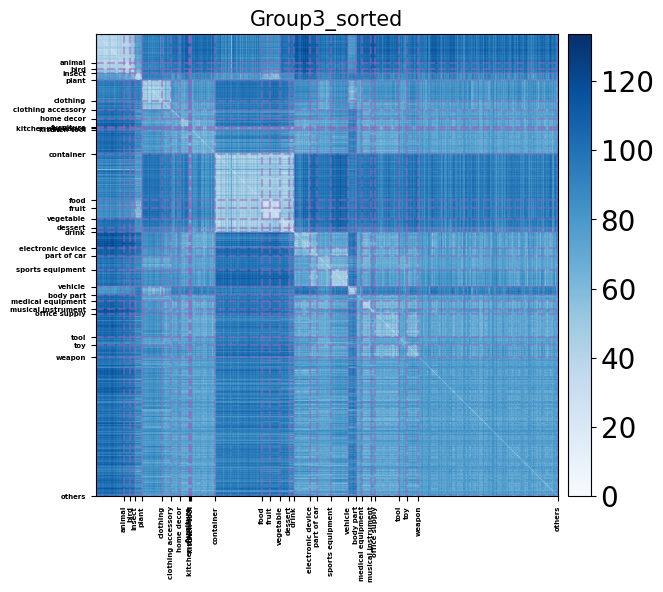

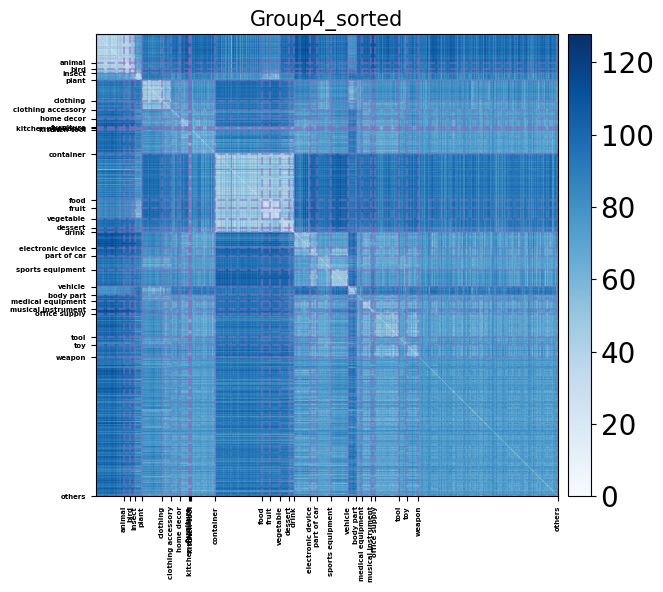

In [9]:
## Dataset No.2 : THINGS
if data_select == "THINGS":
    sim_mat_format = "sorted"
    visualize_matrix = VisualizationConfig(
        figsize=(8, 6), 
        title_size = 15, 
        cmap = 'Blues',
        cbar_ticks_size=20,
        
        draw_category_line=True,
        category_line_color='C4',
        category_line_alpha=0.5,
        category_line_style='dashed',
       
        )
    
    sim_mat = align_representation.show_sim_mat(
        sim_mat_format=sim_mat_format, 
        visualization_config=visualize_matrix,
        fig_dir=None,
        show_distribution=False,
        ticks='category'
    )

## Reperesentation Similarity Aanalysis (RSA)

In [10]:
### arguments for computing RSA
# metric = "pearson" or "spearman" by scipy.stats
# method = "normal" or "all"
#     "normal" : the data to take the RSA is the upper-triangle of sim_mat (numpy.triu_indices(sim_mat.shpe[0], k=1)).
#     "all" : the data to take the RSA is all the values of dis-similarity matrix (sim_mat.flatten()).
align_representation.RSA_get_corr(metric = "pearson", method = 'all')

Correlation Group1 vs Group2 : 0.9726829026802783
Correlation Group1 vs Group3 : 0.9737946068566133
Correlation Group1 vs Group4 : 0.9723621371055615
Correlation Group2 vs Group3 : 0.9733516696970294
Correlation Group2 vs Group4 : 0.9729017105146179
Correlation Group3 vs Group4 : 0.9741935929249503


## Computing GW Alignment.
Optimization results are saved in the folder by "config.data_name" + "representations.name" vs "representation.name".  
If you want to change the name of the saved folder, please change "config.data_name" and "representations.name".

[I 2023-06-13 19:06:39,505] A new study created in RDB with name: THINGS Group2 vs Group3
[I 2023-06-13 19:06:39,544] A new study created in RDB with name: THINGS Group1 vs Group2
[I 2023-06-13 19:06:39,549] A new study created in RDB with name: THINGS Group1 vs Group4
[I 2023-06-13 19:06:39,564] A new study created in RDB with name: THINGS Group1 vs Group3


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:07:52,676] Trial 0 finished with value: 15.083781120449764 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.083781120449764.
[I 2023-06-13 19:07:53,111] Trial 0 finished with value: 15.428993801498649 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801498649.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:07:53,739] Trial 0 finished with value: 23.864782147061312 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 23.864782147061312.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:07:54,349] Trial 0 finished with value: 21.097537642983884 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 21.097537642983884.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:08:39,892] Trial 1 finished with value: 21.433090300387335 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.083781120449764.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:08:40,388] Trial 1 finished with value: 21.844962371193542 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801498649.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:08:41,021] Trial 1 finished with value: 29.63208301181222 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 23.864782147061312.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:08:41,633] Trial 1 finished with value: 26.675064281315652 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 21.097537642983884.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:09:27,759] Trial 2 finished with value: 17.290361817261772 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801498649.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:09:28,206] Trial 2 finished with value: 16.828534778724208 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.083781120449764.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:09:29,209] Trial 2 finished with value: 22.63077878701866 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 21.097537642983884.
[I 2023-06-13 19:09:29,638] Trial 2 finished with value: 25.380600827633437 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 23.864782147061312.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:10:16,035] Trial 3 finished with value: 16.17718746468098 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801498649.
[I 2023-06-13 19:10:16,728] Trial 3 finished with value: 15.77271201924114 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.083781120449764.
[I 2023-06-13 19:10:16,774] A new study created in RDB with name: THINGS Group2 vs Group4


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:10:17,003] A new study created in RDB with name: THINGS Group3 vs Group4


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:10:18,774] Trial 3 finished with value: 21.748075383998618 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 21.097537642983884.
[I 2023-06-13 19:10:19,486] Trial 3 finished with value: 24.54881755579555 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 23.864782147061312.
[I 2023-06-13 19:11:08,588] Trial 0 finished with value: 18.378832401964154 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 18.378832401964154.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:11:19,149] Trial 0 finished with value: 15.453361511720509 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.453361511720509.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:11:33,577] Trial 1 finished with value: 25.0960366584328 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 18.378832401964154.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:11:43,935] Trial 1 finished with value: 22.132145174375395 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.453361511720509.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:11:58,448] Trial 2 finished with value: 20.407411287223383 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 18.378832401964154.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:12:08,686] Trial 2 finished with value: 17.420682197971907 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.453361511720509.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-13 19:12:33,067] Trial 3 finished with value: 16.301637084988887 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.453361511720509.
[I 2023-06-13 19:12:35,719] Trial 3 finished with value: 19.15787996787901 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 18.378832401964154.


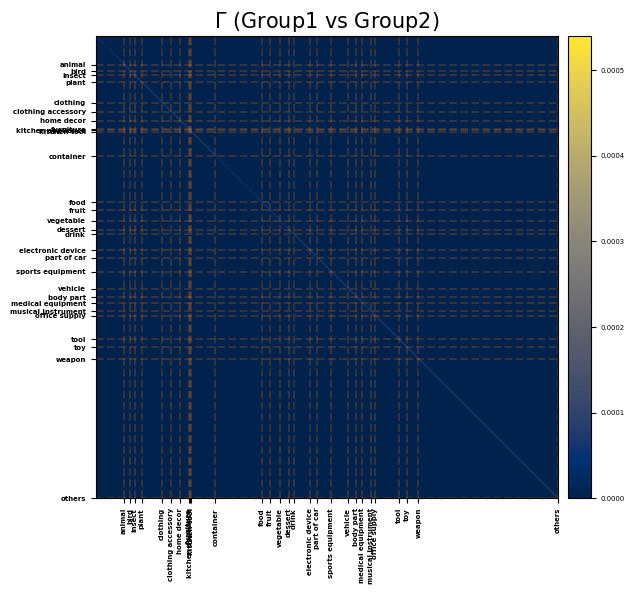

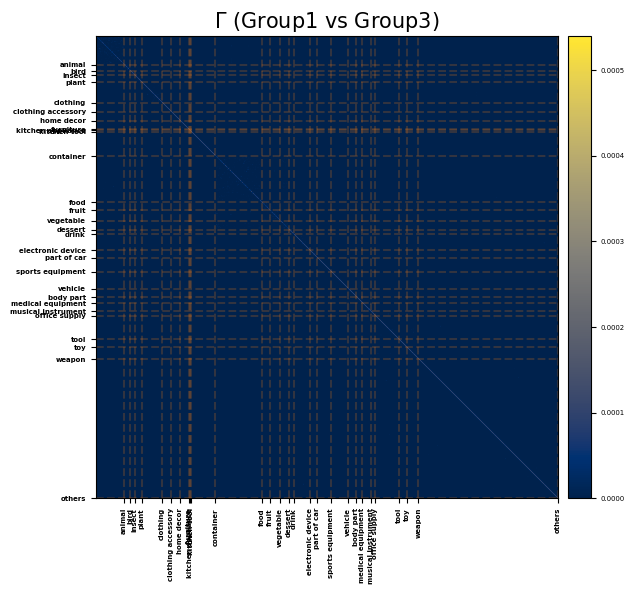

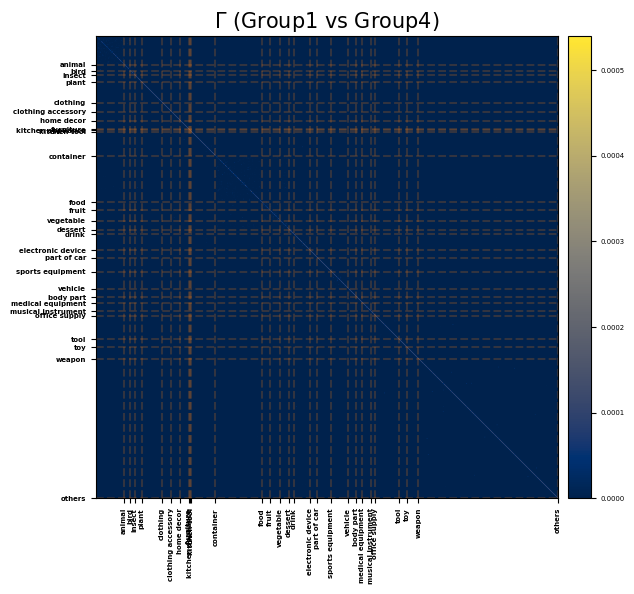

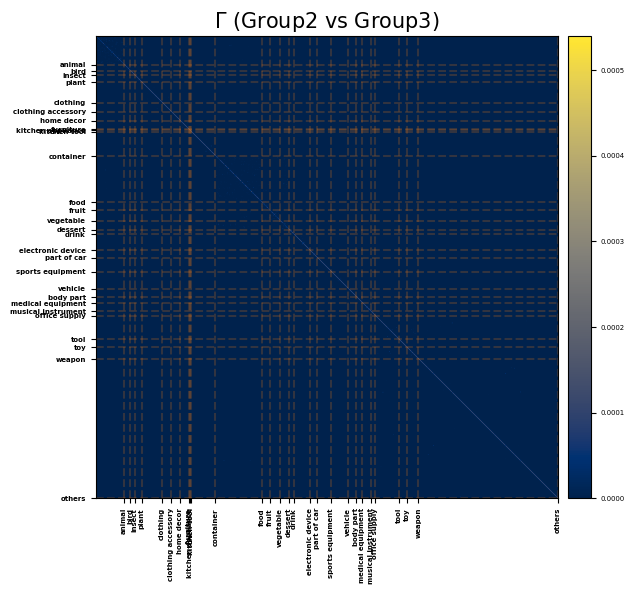

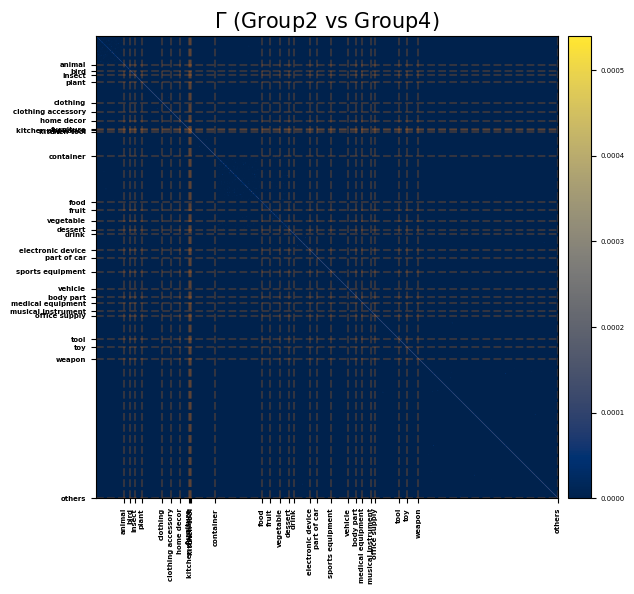

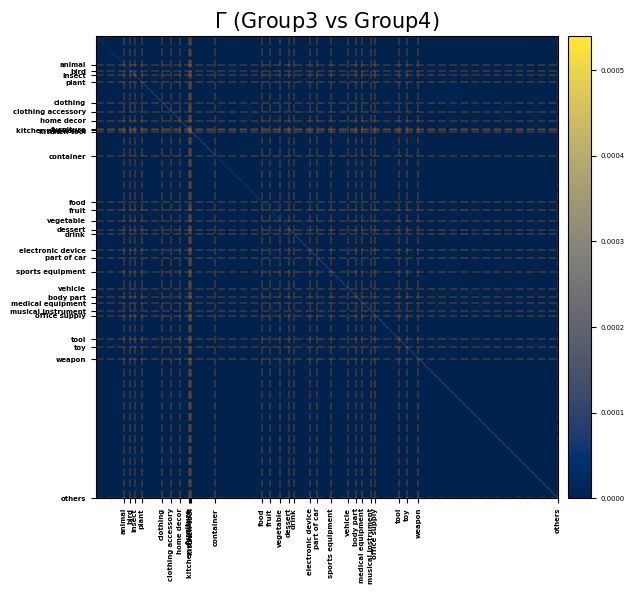

In [11]:
compute_OT = False # If the computation was done and no need for, turn "compute_OT" False, then OT plans calculated before is loaded.

if data_select == "THINGS":
    sim_mat_format = "sorted"
    visualize_matrix = VisualizationConfig(figsize=(8, 6), title_size = 15, category_line_color = 'C1')

    ot_list = align_representation.gw_alignment(
        results_dir = "../results",
        compute_OT = compute_OT,  
        return_data = False, # If True, the data will be stored in `ot_list`.
        return_figure = True,
        OT_format = sim_mat_format, # "default", "sorted" or "both" (= "default" and "sorted").
        visualization_config = visualize_matrix,
        show_log=False, # if True, this will show the figures how the GWD was optimized.
        fig_dir=None, # you can define the path to save the figures (.png). If None, the figures will be saved in the same subfolder in "results_dir"
        ticks = 'category', # you can use "objects" or "category" or "None"
    )

if data_select == "color":
    visualize_matrix = VisualizationConfig(figsize=(10, 10), title_size = 15)

    align_representation.gw_alignment(
        results_dir = "../results",
        compute_OT = compute_OT,
        return_data = False,
        return_figure = True,
        OT_format = sim_mat_format, # "default"
        visualization_config = visualize_matrix,
    )

In [12]:
## Show how the GWD was optimized
# align_representation.show_optimization_log(results_dir="../results")

# Step 4: Evaluating the unsupervised alignment

Top k accuracy : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             89.967638         88.349515         86.623517         88.619202   
5             97.303128         96.763754         96.548004         96.709817   
10            98.651564         98.220065         98.274002         98.543689   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             89.644013         87.324703  
5             97.033441         96.224380  
10            98.381877         97.734628  
Mean : 
 top_n
1     88.112190
5     96.655879
10    98.230852
dtype: float64


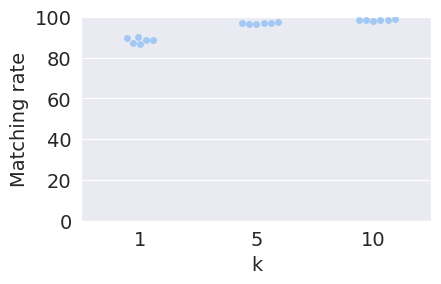

In [13]:
## Calculate the accuracy of the optimized OT matrix
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

K nearest matching rate : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             78.586839         76.860841         78.425027         74.865156   
5             94.282632         92.448759         93.635383         92.179072   
10            97.303128         95.846818         96.494067         95.469256   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             77.076591         78.640777  
5             92.826321         93.635383  
10            96.278317         96.386192  
Mean : 
 top_n
1     77.173679
5     92.944984
10    96.094930
dtype: float64


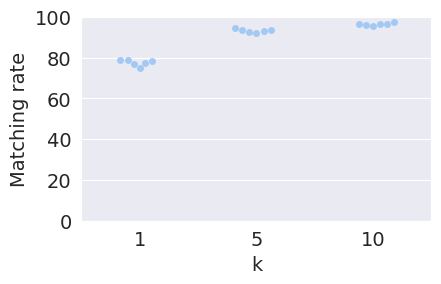

In [14]:
## Calculate the matching rate of k-nearest neighbors of embeddings
## Matching rate of k-nearest neighbors 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

## Visualizing the aligned embeddings

           Number
bird           25
insect         17
plant          28
clothing       82
furniture      33
fruit          33
drink          19
vehicle        67


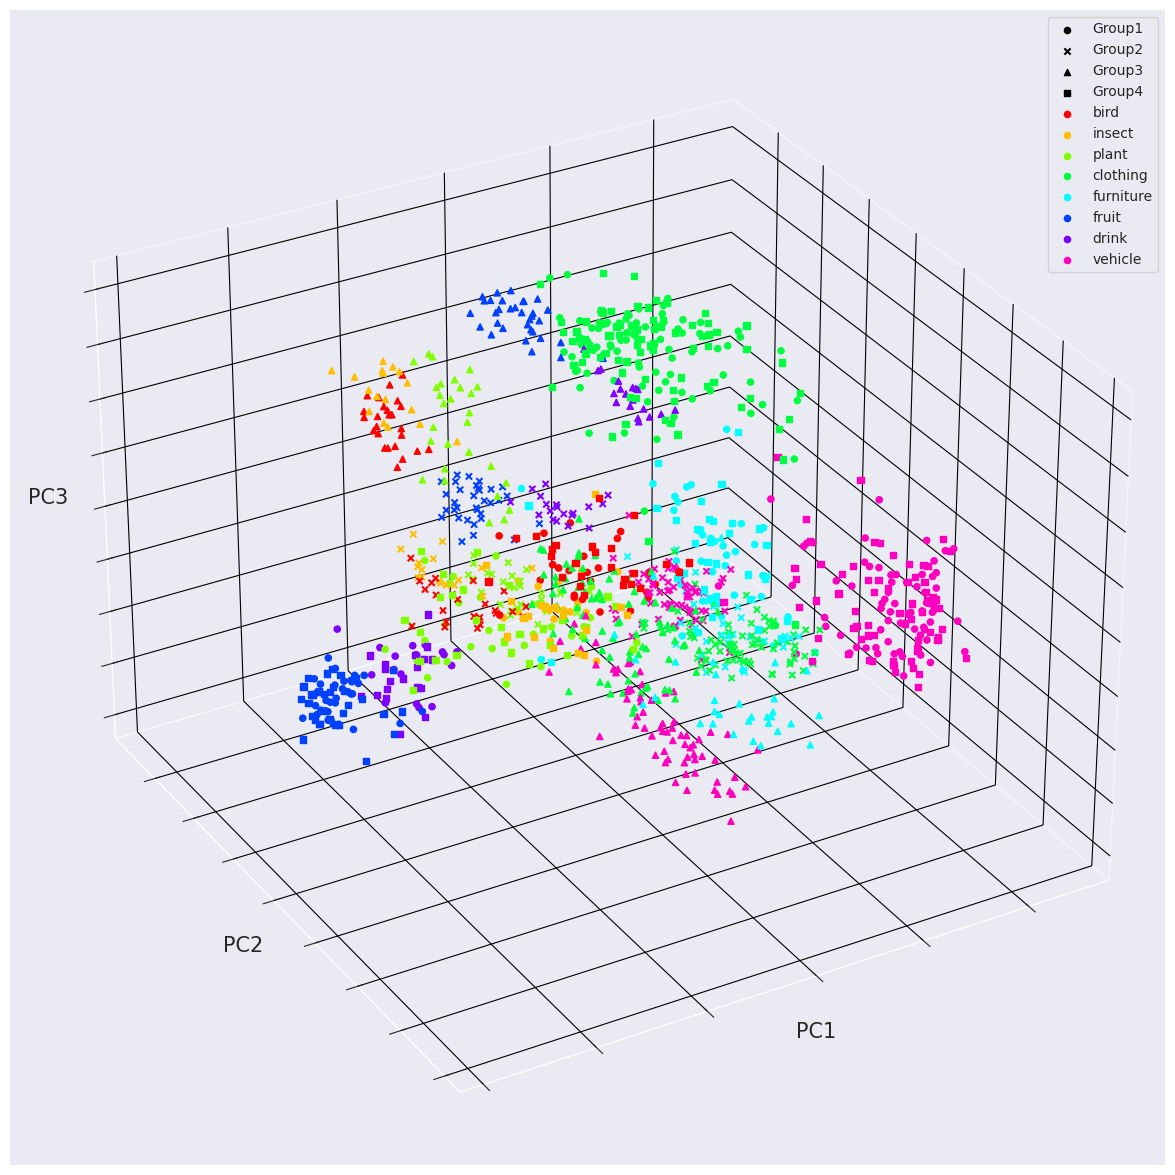

In [15]:
# Set color labels and category data if exist.
if data_select == "THINGS":
    category_name_list = ["bird", "insect", "plant", "clothing",  "furniture", "fruit", "drink", "vehicle"]
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)   
    object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat, category_name_list, show_numbers = True)  
    
    visualization_embedding = VisualizationConfig(
        figsize=(15, 15), 
        xlabel="PC1",
        ylabel="PC2", 
        zlabel="PC3", 
        marker_size=20,
        legend_size=10
    )
    
    align_representation.visualize_embedding(
        dim=3,  
        visualization_config=visualization_embedding,
        category_name_list=category_name_list, 
        category_idx_list=category_idx_list, 
        num_category_list=num_category_list,
    )

In [16]:
if data_select == 'color':
    file_path = "../data/color_dict.csv"
    data_color = pd.read_csv(file_path)
    color_labels = data_color.columns.values
    
    visualization_embedding = VisualizationConfig(
        color_labels=color_labels, 
        figsize=(15, 15), 
        xlabel="PC1", 
        ylabel="PC2",
        zlabel="PC3", 
        legend_size=10
    )
    
    align_representation.visualize_embedding(
        dim=3, 
        visualization_config=visualization_embedding
    )

## category level analysis
User can use this analysis if the dataset has category info.

In [17]:
## Calclate the category level accuracy
if data_select == "THINGS":
    align_representation.calc_category_level_accuracy(category_mat=category_mat)

Group1 vs Group2 :  97.24919093851133
Group1 vs Group3 :  97.14131607335491
Group1 vs Group4 :  96.60194174757282
Group2 vs Group3 :  97.24919093851133
Group2 vs Group4 :  97.24919093851133
Group3 vs Group4 :  96.87162891046385
